In [125]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy import signal 
import pyaudio

In [126]:
sampFreq, sound = wavfile.read('../audio/bad_grand.wav')
sound.dtype, sampFreq

(dtype('int16'), 44100)

The sound pressure values are mapped to integer values that can range from -2^15 to (2^15)-1. The samples are taken 44100 times per second.   
We can convert our sound (numpy) array to floating point values ranging from -1 to 1.

In [127]:
sound = sound / 2.0**15
sound.shape

(9829312, 2)

The wav file has two channels and 8422336 sample points.   

In [128]:
length_in_s = sound.shape[0] / sampFreq
print(length_in_s)

222.8868934240363


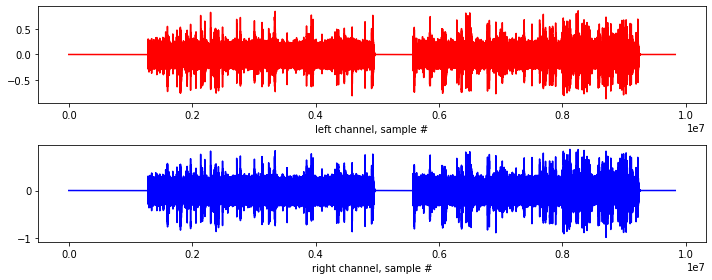

In [129]:
plt.figure(figsize=(10, 4))
plt.subplot(2,1,1)
plt.plot(sound[:,0], 'r')
plt.xlabel("left channel, sample #")
plt.subplot(2,1,2)
plt.plot(sound[:,1], 'b')
plt.xlabel("right channel, sample #")
plt.tight_layout()

Text(0, 0.5, 'signal, relative units')

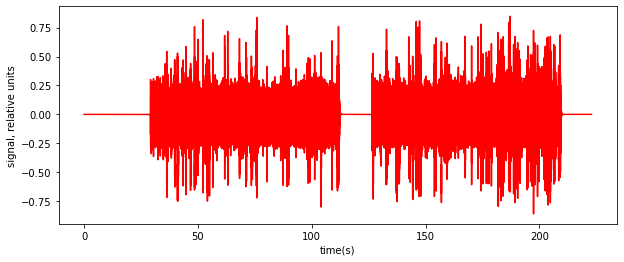

In [130]:
time = np.arange(sound.shape[0]) / sound.shape[0] * length_in_s
plt.figure(figsize=(10, 4))
plt.plot(time, sound[:,0], 'r')
plt.xlabel("time(s)")
plt.ylabel("signal, relative units")

In [131]:
sound = sound[:,0]

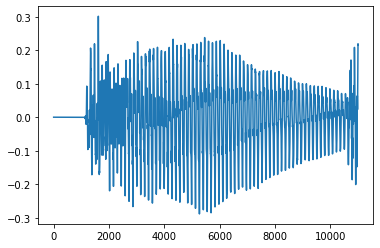

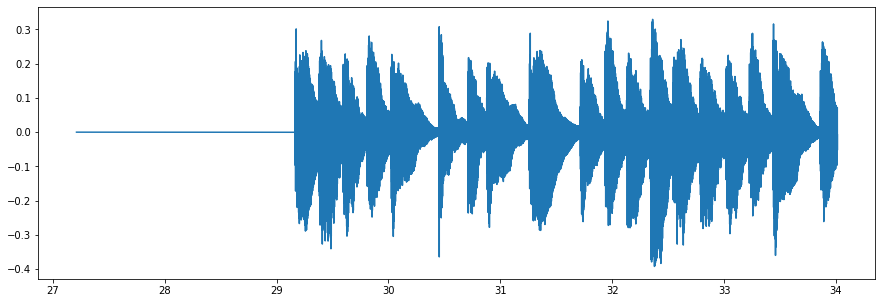

In [132]:
first = sound[1285000: 1296000]
plt.plot(first)

start = sound[1200000:1500000]
plt.figure(figsize=(15, 5))
plt.plot(time[1200000:1500000], start)

From listening to the audio and trying to map where the pitches change, the assumption is that the note changes at the peaks

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(sound[:2000000])
plt.xlim(1500000, 2000000)

peaks = signal.find_peaks(sound, height=0.15, threshold=0, distance=7000)[0]

ys = [sound[p] for p in peaks]

plt.plot(peaks, ys, '.r')
for p in peaks:
        plt.axvline(p, color='g')

ans = peaks

In [ ]:
# slice waveform into indices for each note
ff = []
for i in range(1, len(ans)):
    ff.append((ans[i-1], ans[i]))
ff[0]

(1286614, 1296568)

Text(0, 0.5, 'Amplitude, units')

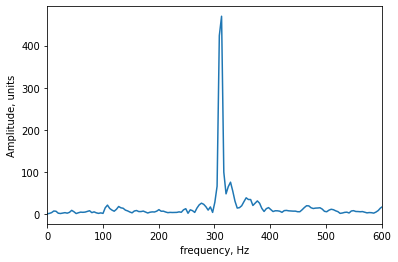

In [ ]:
# find hz using fourier transfrom
fft_spectrum = np.fft.rfft(first)
freq = np.fft.rfftfreq(first.size, d=1./sampFreq)
fft_spectrum_abs = np.abs(fft_spectrum)
plt.plot(freq, fft_spectrum_abs)
plt.xlim(0, 600)
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")

In [ ]:
def find_freq(interval):
    start, stop = interval
    s = sound[start:stop]

    fft_spectrum = np.abs(np.fft.rfft(s))
    freq = np.fft.rfftfreq(s.size, d=1./sampFreq)
    i = np.argmax(fft_spectrum)

    # this is just an optimization to make this more accurate since i know that all the notes in this song are within the range.
    ftt = np.copy(fft_spectrum)
    while freq[i] > 800 or freq[i] < 200:
        ftt = np.delete(ftt, i)
        i = np.argmax(ftt)

    return ((stop-start), freq[i])
find_freq(ff[0])

(9954, 310.126582278481)

In [ ]:
p = pyaudio.PyAudio()
sampRate = 44100 
# for paFloat32 sample values must be in range [-1.0, 1.0]
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=sampRate,
                output=True)

all_samples = []

def play(freq):
    d, f = freq
    # covert duration into second
    duration = d / sampRate

    if duration > 5:
        f = 0

    volume = 0.5  # range [0.0, 1.0]
    samples = (np.sin(2*np.pi*np.arange(sampRate*duration)*f/sampRate)).astype(np.float32)
    stream.write(volume*samples)

    all_samples.extend(volume*samples)

play(find_freq(ff[0]))

In [ ]:
all_notes = []
for f in ff:
    peroid, note_freq = find_freq(f)
    all_notes.append(note_freq)
    play((peroid, note_freq))

all_samples = np.array(all_samples)
wavfile.write("out_peaks.wav", sampRate, all_samples)

stream.stop_stream()
stream.close()

In [ ]:
base_f = {
    16.35: "C",
    17.32: "C#/Db",
    18.35: "D",
    19.45: "D#/Eb",
    20.60: "E",
    21.83: "F",
    23.12: "F#/Gb",
    24.50: "G",
    25.96: "G#/Ab",
    27.50: "A",
    29.14: "A#/Bb",
    30.87: "B",
}


predicted = []
def find_note(nf):
    note = ""
    min_so_far = 100
    while nf > 32:
        nf = nf /2
    for f in base_f:
        diff = abs(nf - f)
        if diff < min_so_far:
            min_so_far = diff
            note = base_f.get(f)
    predicted.append(note)

for nf in all_notes[:30]:
    find_note(nf)

actual = ['D#/Eb', 'F', 'F#/Gb', 'G#/Ab', 'A#/Bb', 'D#/Eb', 'C#/Db', 'A#/Bb', 'D#/Eb', 'A#/Bb', 'G#/Ab', 'F#/Gb', 'F', 'D#/Eb', 'F', 'F#/Gb', 'G#/Ab', 'A#/Bb', 
            'G#/Ab', 'F#/Gb', 'F', 'D#/Eb', 'F', 'F#/Gb', 'F', 'D#/Eb', 'D', 'F', 'D#/Eb', 'F', 'F#/Gb', 'G#/Ab', 'A#/Bb', 'D#/Eb', 'C#/Db', 'A#/Bb', 'D#/Eb', 
            'D#/Eb', 'A#/Bb', 'G#/Ab', 'F#/Gb', 'F', 'D#/Eb', 'F', 'F#/Gb', 'G#/Ab', 'A#/Bb', 'G#/Ab', 'F#/Gb', 'F', 'F', 'F#/Gb', 'G#/Ab', 'A#/Bb']

# print(actual)
print(predicted)
print(predicted == actual)

['D#/Eb', 'F', 'F#/Gb', 'G#/Ab', 'A#/Bb', 'D#/Eb', 'C#/Db', 'A#/Bb', 'D#/Eb', 'D#/Eb', 'A#/Bb', 'G#/Ab', 'F#/Gb', 'F', 'D#/Eb', 'F', 'F#/Gb', 'G#/Ab', 'A#/Bb', 'G#/Ab', 'F#/Gb', 'F', 'D#/Eb', 'F', 'F#/Gb', 'F', 'D#/Eb', 'D', 'F', 'D#/Eb']
False


For the first 50 notes, the accuracy is 100%. There maybe some error throughout the song, mostly due to error in dectecting the interval for a note.   
The notes written here do not specify which octave(overtone) they belong to.   
In the output audio, there maybe some pitches that sound overly high. The reason is the octaves predicted are wrong, however most of them are correct notes.